Pinn to solve lorentz equation

first we import the data set and implement a way to sample the magnetic field

In [4]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Load the magnetic field data from a CSV file
data = pd.read_csv(
    "results_homo.csv"
)  # Ensure the file has columns: x, y, z, Bx, By, Bz
positions = data[["x", "y", "z"]].values  # Position data
fields = data[["Bx", "By", "Bz"]].values  # Magnetic field components

# Create a k-d tree for efficient nearest-neighbor queries
tree = cKDTree(positions)


def magnetic_field(position):
    """
    Query the magnetic field for a given position.
    Args:
        position (list or np.array): [x, y, z] position in space.
    Returns:
        np.array: [Bx, By, Bz] magnetic field vector at the queried position.
    """
    _, idx = tree.query(position)  # Find nearest neighbor
    return fields[idx]

In [2]:
data.head(10)

,x,y,z,Bx,By,Bz
0,0.03139,0.02795,-0.03004,0.002615,3.259720e-03,0.003193
1,-0.04792,-0.01556,0.04822,0.002225,1.149863e-03,0.000000
2,-0.00440,-0.01597,0.02577,0.006843,2.228426e-02,-0.008239
3,0.04945,-0.03221,-0.01103,0.000000,-1.110008e-03,0.007755
4,-0.00804,-0.01265,-0.03829,-0.001783,-3.266066e-03,-0.007275
5,-0.02229,-0.02712,0.00005,-0.002743,-4.353262e-03,0.016515
6,0.01144,0.04998,-0.00289,-0.000730,-3.433735e-19,0.011642
7,-0.00584,-0.01543,-0.00063,-0.010433,-1.899825e-02,0.137786
8,-0.03476,-0.04805,0.04129,0.002248,0.000000e+00,0.002022
9,-0.01297,-0.04224,0.00540,0.000193,5.680308e-04,0.010637


In [5]:
import torch
import torch.nn as nn
m = 9.109e-31  # electron mass in kg
q = -1.602e-19  # electron charge in Coulombs (or +ve if you want a proton)


class TrajectoryPINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for predicting the trajectory of a charged particle.
    This network is designed to take a single time input and predict the spatial coordinates
    (x, y, z) of the particle at that time.
    """

    def __init__(self):
        """
        Initialize the neural network structure.
        The network consists of a series of fully connected (linear) layers with Tanh activation functions.
        """
        super().__init__()  # Call the parent class (nn.Module) constructor

        # Define the network architecture using nn.Sequential.
        # The architecture includes:
        # - An input layer that takes a single value (time t)
        # - Three hidden layers with 128 neurons each and Tanh activation functions
        # - An output layer with 3 neurons, representing the x(t), y(t), and z(t) coordinates
        self.net = nn.Sequential(
            nn.Linear(
                1, 128
            ),  # Input layer: maps 1 input (time t) to 128 hidden neurons
            nn.Tanh(),  # Activation function: Tanh introduces non-linearity
            nn.Linear(
                128, 128
            ),  # Hidden layer: maps 128 neurons to another 128 neurons
            nn.Tanh(),  # Activation function: Tanh
            nn.Linear(128, 128),  # Another hidden layer with 128 neurons
            nn.Tanh(),  # Activation function: Tanh
            nn.Linear(128, 3),  # Output layer: maps 128 neurons to 3 outputs (x, y, z)
        )

    def forward(self, t):
        """
        Perform the forward pass of the network.

        Args:
            t (Tensor): A tensor containing the time input(s) for which to predict the trajectory.
                        Shape: (batch_size, 1), where each row is a single time value.

        Returns:
            Tensor: A tensor containing the predicted (x, y, z) coordinates for the input times.
                    Shape: (batch_size, 3), where each row represents [x(t), y(t), z(t)].
        """
        return self.net(t)  # Pass the input t through the network and return the output

In [6]:
def physics_loss(model, t, s0, v0, device, display=False):
    """
    Compute the loss function for the PINN using the Lorentz force equation.
    Args:
        model (nn.Module): The PINN model.
        t (torch.Tensor): Time values, shape: (N, 1).
        s0 (torch.Tensor): Initial position [x0, y0, z0].
        v0 (torch.Tensor): Initial velocity [vx0, vy0, vz0].
        device (torch.device): Device (CPU or GPU).
    Returns:
        torch.Tensor: The total loss value.
    """
    # Enable autograd for time
    t.requires_grad = True

    # Predicted positions, shape: (N, 3)
    s = model(t)

    # Check shape of s
    if s.shape[1] != 3:
        raise ValueError(f"Expected model output to have shape (N, 3), got {s.shape}")

    # ------------------------------------------------------------------
    # Compute velocity v = ds/dt by taking partial derivatives of each
    # dimension of s w.r.t. t individually, then stacking them.
    # ------------------------------------------------------------------
    v_components = []
    for i in range(3):
        # s[:, i] has shape (N,)
        # We'll compute d(s[:, i]) / dt => shape (N,)
        grad_i = torch.autograd.grad(
            s[:, i],  # outputs
            t,  # inputs
            grad_outputs=torch.ones_like(s[:, i]),
            create_graph=True,
        )[
            0
        ]  # shape: (N, 1)

        v_components.append(grad_i.reshape(-1))  # make it (N,)

    # Stack into (N, 3)
    v = torch.stack(v_components, dim=1)
    # Debugging: Check velocity shape
    if v.shape[1] != 3:
        raise ValueError(f"Expected velocity to have shape (N, 3), got {v.shape}")

    # ------------------------------------------------------------------
    # Compute acceleration a = dv/dt similarly.
    # ------------------------------------------------------------------
    a_components = []
    for i in range(3):
        grad_i = torch.autograd.grad(
            v[:, i], t, grad_outputs=torch.ones_like(v[:, i]), create_graph=True
        )[0]

        a_components.append(grad_i.reshape(-1))

    a = torch.stack(a_components, dim=1)
    # Debugging: Check acceleration shape
    if a.shape[1] != 3:
        raise ValueError(f"Expected acceleration to have shape (N, 3), got {a.shape}")

    # Query magnetic field at predicted positions
    B_values = torch.stack(
        [
            torch.tensor(
                magnetic_field(pos.cpu().detach().numpy()), dtype=torch.float32
            )
            for pos in s
        ]
    ).to(
        device
    )  # Shape: (N, 3)
    #print(B_values)
    # Debugging: Check B_values shape
    if B_values.shape[1] != 3:
        raise ValueError(
            f"Expected B_values to have shape (N, 3), got {B_values.shape}"
        )

    # Lorentz force residual
    lorentz_residual = m * a - q * torch.cross(v, B_values, dim=1)
    physics_loss_val = torch.mean(lorentz_residual**2)

    # Initial conditions loss
    ic_loss = torch.mean((s[0] - s0) ** 2) + torch.mean((v[0] - v0) ** 2)
    if display:
        print("current physics loss")
        print(physics_loss_val)
        print("current ic loss")
        print(ic_loss)
    return physics_loss_val + 2* ic_loss

In [13]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrajectoryPINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=12e-4)
# Initialize a list to store loss values
loss_history = []
# Initial conditions
s0 = torch.tensor([[0.0, 0.007, -0.05]], device=device)  # Initial position
v0 = torch.tensor([[0.0, 0.0, 1e6]], device=device)  # Initial velocity (z-direction)
t_train = torch.linspace(0, 1e-5, 1000, device=device).unsqueeze(1)  # Time values

# Training loop
for epoch in range(50000):
    optimizer.zero_grad()
    loss = physics_loss(model, t_train, s0, v0, device, display)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    display = False
    if epoch % 400== 0:
        display = True
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        if loss.item() < 1e-4: #early stopp
            break

# Save the trained model
torch.save(model.state_dict(), "trajectory_pinn_3d.pth")
print("Training complete and model saved.")

Epoch 0, Loss: 666666663936.0
current physics loss
tensor(1.6816e-44, grad_fn=<MeanBackward0>)
current ic loss
tensor(3.3333e+11, grad_fn=<AddBackward0>)
current physics loss
tensor(1.0054e-32, grad_fn=<MeanBackward0>)
current ic loss
tensor(2.4966e+11, grad_fn=<AddBackward0>)
Epoch 500, Loss: 407392747520.0
current physics loss
tensor(1.6934e-31, grad_fn=<MeanBackward0>)
current ic loss
tensor(8.2636e+09, grad_fn=<AddBackward0>)
Epoch 1000, Loss: 41199500.0
current physics loss
tensor(1.2891e-30, grad_fn=<MeanBackward0>)
current ic loss
tensor(7008.3345, grad_fn=<AddBackward0>)
Epoch 1500, Loss: 6.511754989624023
current physics loss
tensor(3.0561e-30, grad_fn=<MeanBackward0>)
current ic loss
tensor(3.0007, grad_fn=<AddBackward0>)
Epoch 2000, Loss: 3.566396474838257
current physics loss
tensor(2.5219e-30, grad_fn=<MeanBackward0>)
current ic loss
tensor(1.7832, grad_fn=<AddBackward0>)
current physics loss
tensor(3.1512e-30, grad_fn=<MeanBackward0>)
current ic loss
tensor(1.0957, grad_f

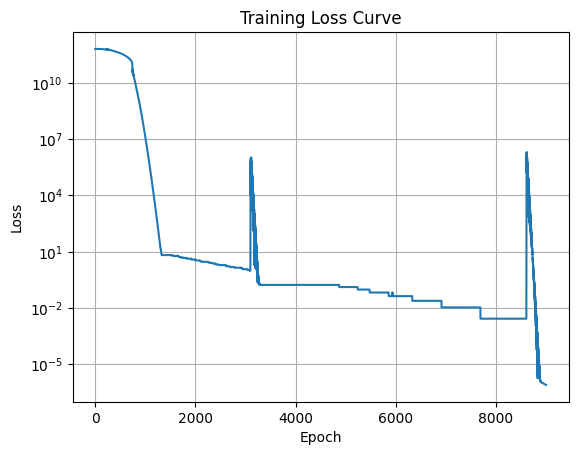

In [34]:
# Plot the loss curve
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")  # Set y-axis to logarithmic scale

plt.title("Training Loss Curve")
plt.grid()
plt.show()

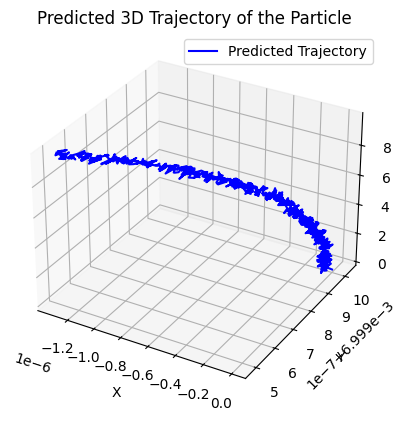

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the trained model
model = TrajectoryPINN().to(device)
model.load_state_dict(torch.load("trajectory_pinn_3d.pth"))
model.eval()

# Generate predictions
t_test = torch.linspace(0, 1e-5, 1000, device=device).unsqueeze(1)  # Time values
with torch.no_grad():
    s_pred = model(t_test).cpu().numpy()  # Predicted positions

# Extract coordinates
x_pred, y_pred, z_pred = s_pred[:, 0], s_pred[:, 1], s_pred[:, 2]

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_pred, y_pred, z_pred, label="Predicted Trajectory", color="blue")
ax.set_title("Predicted 3D Trajectory of the Particle")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

In [38]:
import plotly.graph_objects as go
import torch

# Load the trained model
model = TrajectoryPINN().to(device)
model.load_state_dict(torch.load("trajectory_pinn_3d.pth"))
model.eval()

# Generate predictions
t_test = torch.linspace(0, 1e-5, 1000, device=device).unsqueeze(1)  # Time values
with torch.no_grad():
    s_pred = model(t_test).cpu().numpy()  # Predicted positions

# Extract coordinates
x_pred, y_pred, z_pred = s_pred[:, 0], s_pred[:, 1], s_pred[:, 2]

# Create interactive 3D plot
fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=x_pred,
        y=y_pred,
        z=z_pred,
        mode="lines",
        line=dict(color="blue", width=2),
        name="Predicted Trajectory",
    )
)

# Add titles and labels
fig.update_layout(
    title="Predicted 3D Trajectory of the Particle",
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
)

# Show the plot
fig.show()

In [39]:
import numpy as np
import plotly.graph_objects as go
import math


def create_coil_geometry(nwindings=6, wireradius=0.001, coilradius=0.01):
    """
    Generates the 3D coordinates of a coil for visualization.

    Parameters:
    nwindings (int): Number of windings in the coil. Default is 6.
    wireradius (float): Radius of the wire used to create the coil. Default is 0.001.
    coilradius (float): Radius of the coil. Default is 0.01.

    Returns:
    numpy.ndarray: 3D coordinates of the coil.
    """
    t = np.linspace(0, 2 * np.pi * nwindings, 1000)  # Parameter for the coil
    x = coilradius * np.cos(t)
    y = coilradius * np.sin(t)
    z = np.linspace(-nwindings * wireradius, nwindings * wireradius, len(t))
    return x, y, z


# Generate the coil geometry
x_coil, y_coil, z_coil = create_coil_geometry(
    nwindings=6, wireradius=0.001, coilradius=0.01
)

# Generate predictions (dummy example for demonstration)
x_pred = np.sin(np.linspace(0, 2 * np.pi, 100))
y_pred = np.cos(np.linspace(0, 2 * np.pi, 100))
z_pred = np.linspace(-0.1, 0.1, 100)

# Create interactive 3D plot
fig = go.Figure()

# Add the predicted trajectory
fig.add_trace(
    go.Scatter3d(
        x=x_pred,
        y=y_pred,
        z=z_pred,
        mode="lines",
        line=dict(color="blue", width=2),
        name="Predicted Trajectory",
    )
)

# Add the coil geometry
fig.add_trace(
    go.Scatter3d(
        x=x_coil,
        y=y_coil,
        z=z_coil,
        mode="lines",
        line=dict(color="red", width=2),
        name="Coil Geometry",
    )
)

# Add titles and labels
fig.update_layout(
    title="3D Visualization of Predicted Trajectory and Coil Geometry",
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
)

# Show the plot
fig.show()

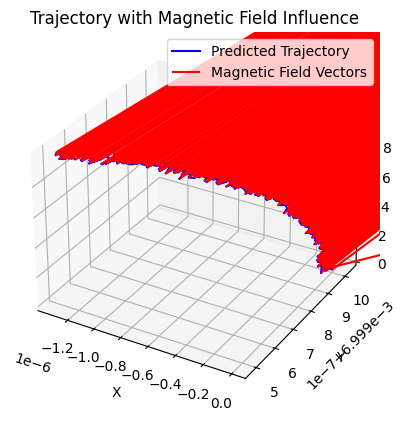

In [36]:
# Compute the magnetic field at each predicted position
B_pred = np.array(
    [magnetic_field(pos) for pos in s_pred]
)  # Magnetic field vectors at predicted positions

# Normalize the magnetic field vectors for visualization
B_norm = np.linalg.norm(B_pred, axis=1, keepdims=True)
B_unit = B_pred / (B_norm + 1e-8)  # Add small value to avoid division by zero

# 3D Plot with magnetic field vectors
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the trajectory
ax.plot(x_pred, y_pred, z_pred, label="Predicted Trajectory", color="blue")

# Plot magnetic field vectors as quivers
ax.quiver(
    x_pred,
    y_pred,
    z_pred,  # Trajectory positions
    B_unit[:, 0],
    B_unit[:, 1],
    B_unit[:, 2],  # Magnetic field direction
    length=0.01,  # Scale for arrow length
    color="red",
    label="Magnetic Field Vectors",
)

ax.set_title("Trajectory with Magnetic Field Influence")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

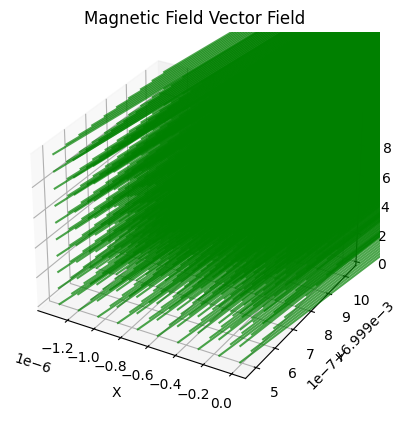

In [37]:
# Sample a grid of positions in the space
x_grid = np.linspace(min(x_pred), max(x_pred), 10)
y_grid = np.linspace(min(y_pred), max(y_pred), 10)
z_grid = np.linspace(min(z_pred), max(z_pred), 10)
X, Y, Z = np.meshgrid(x_grid, y_grid, z_grid)

# Compute magnetic field at each grid point
B_vectors = np.array(
    [
        magnetic_field([x, y, z])
        for x, y, z in zip(X.flatten(), Y.flatten(), Z.flatten())
    ]
)
Bx, By, Bz = B_vectors[:, 0], B_vectors[:, 1], B_vectors[:, 2]

# Reshape for visualization
Bx = Bx.reshape(X.shape)
By = By.reshape(Y.shape)
Bz = Bz.reshape(Z.shape)

# 3D Quiver Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.quiver(
    X,
    Y,
    Z,  # Grid positions
    Bx,
    By,
    Bz,  # Magnetic field components
    length=0.05,  # Scale for arrow length
    color="green",
    alpha=0.7,
)

ax.set_title("Magnetic Field Vector Field")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [40]:
import numpy as np
import plotly.graph_objects as go

# Constants for the particle
me = 9.109383713928e-31  # Mass of electron (kg)
qe = -1.602176634e-19  # Charge of electron (C)

# Initial conditions
s0 = np.array([0, 0.007, -0.05])  # Initial position (m)
v0 = np.array([0, 0, 1e6])  # Initial velocity (m/s)
q = qe  # Charge
m = me  # Mass


# Magnetic field (simplified model for demonstration)
def magnetic_field(position):
    """
    Simplified magnetic field function for the coil.
    For demonstration, assume a constant B field along Z-axis.
    """
    return np.array([0, 0, 1])  # Tesla (T)


# Runge-Kutta 4th order method
def runge_kutta_4(dt, t_max):
    t = 0
    s = s0
    v = v0
    positions = [s]

    while t < t_max:
        # RK4 steps
        B = magnetic_field(s)
        k1_v = (q / m) * np.cross(v, B)
        k1_s = v

        k2_v = (q / m) * np.cross(v + 0.5 * dt * k1_v, B)
        k2_s = v + 0.5 * dt * k1_v

        k3_v = (q / m) * np.cross(v + 0.5 * dt * k2_v, B)
        k3_s = v + 0.5 * dt * k2_v

        k4_v = (q / m) * np.cross(v + dt * k3_v, B)
        k4_s = v + dt * k3_v

        v = v + (dt / 6) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
        s = s + (dt / 6) * (k1_s + 2 * k2_s + 2 * k3_s + k4_s)

        positions.append(s)
        t += dt

    return np.array(positions)


# Calculate numerical trajectory
dt = 1e-9  # Time step (s)
t_max = 1e-6  # Total simulation time (s)
numerical_trajectory = runge_kutta_4(dt, t_max)

# Extract coordinates
x_num, y_num, z_num = (
    numerical_trajectory[:, 0],
    numerical_trajectory[:, 1],
    numerical_trajectory[:, 2],
)

# Generate predicted trajectory (for comparison)
x_pred = np.sin(np.linspace(0, 2 * np.pi, 100))
y_pred = np.cos(np.linspace(0, 2 * np.pi, 100))
z_pred = np.linspace(-0.1, 0.1, 100)


# Coil geometry
def create_coil_geometry(nwindings=6, wireradius=0.001, coilradius=0.01):
    t = np.linspace(0, 2 * np.pi * nwindings, 1000)
    x = coilradius * np.cos(t)
    y = coilradius * np.sin(t)
    z = np.linspace(-nwindings * wireradius, nwindings * wireradius, len(t))
    return x, y, z


x_coil, y_coil, z_coil = create_coil_geometry()

# Interactive 3D plot
fig = go.Figure()

# Add numerical trajectory
fig.add_trace(
    go.Scatter3d(
        x=x_num,
        y=y_num,
        z=z_num,
        mode="lines",
        line=dict(color="green", width=2),
        name="Numerical Trajectory",
    )
)

# Add predicted trajectory
fig.add_trace(
    go.Scatter3d(
        x=x_pred,
        y=y_pred,
        z=z_pred,
        mode="lines",
        line=dict(color="blue", width=2),
        name="Predicted Trajectory",
    )
)

# Add coil geometry
fig.add_trace(
    go.Scatter3d(
        x=x_coil,
        y=y_coil,
        z=z_coil,
        mode="lines",
        line=dict(color="red", width=2),
        name="Coil Geometry",
    )
)

# Add titles and labels
fig.update_layout(
    title="3D Visualization of Trajectories and Coil Geometry",
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
)

# Show the plot
fig.show()